In [32]:
# 导入所需要的包
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jieba

import jieba
import matplotlib.pyplot as plt
import pandas as pd
from imageio import imread  # pip install pillow
# 导入transformers
import transformers
from transformers import BertModel, BertTokenizer,BertConfig, AdamW, get_linear_schedule_with_warmup

from transformers import AutoModel, AutoTokenizer,AutoConfig, AdamW, get_linear_schedule_with_warmup

# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [33]:
# 读取数据
train = pd.read_excel('./data/data.xlsx')
test = pd.read_excel('./data/test.xlsx')
data_数据说明 = pd.read_excel('./data/字段说明.xlsx')

In [34]:
test.head()

,target,userId,sellerId,timestamp,comment
0,NaN,72916,11976,2020-10-01 12:38:17,text：买的人很多，味道好，是十年以上的老店了~~~~\n
1,NaN,39091,34918,2020-10-01 17:35:04,原来是辣的流泪，所以叫伤心凉粉。厉害，味道不错，不过吃完还想吃。\n
2,NaN,289933,59229,2020-10-01 21:00:17,text：外卖好快的，适合中午点
3,NaN,77764,27100,2020-10-02 06:40:07,text：整体感觉就是一般，味道也一般，可能是个人因素哈．\n
4,NaN,24687,30939,2020-10-02 07:28:33,text：我不喜欢


# 任务五：建立餐饮服务评论的情感倾向模型，并对模型的性能和误差进行评估。基于模型对附件中的测试数据 test.xlsx 进行评测，将评测结果补充到第一列中，并将此文件一起上传到竞赛平台。

In [35]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 固定随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 查看正负标签分布

In [36]:
train

,target,userId,sellerId,timestamp,comment
0,1,127,1708,2019-10-01 00:57:45.000003,text：订餐1个半小时不见餐，催了还挂电话！☆ ☆ ☆
1,1,1661,886,2019-10-01 00:42:07.000001,text：太不靠谱！× × 不是漏发订单就是菜送错了，要不就早送一小时！！！× ×
2,0,92758,10612,2019-10-01 00:51:18.000000,text：超级超级喜欢吃，每次去都好开心，口味很好，建议手套多戴几双，吃完之后的形象是不太好...
3,0,1639,1699,2019-10-03 00:01:56.000001,text：谢谢快递哥哥，非常准时，辛苦啦
4,1,241839,36556,2019-10-01 00:07:56.000004,非常差得餐厅，上菜非常慢，且贵！属于可以在餐厅饿死的那种\n，面条没有味道，一碗28，坑死爹...
...,...,...,...,...,...
17948,0,34025,24833,2020-09-25 23:15:36.000003,"text：感觉这里好像发挥不是很稳定,来了几此,有好有坏.吃日料主要就关注三文鱼,这里的属于..."
17949,1,656,901,2020-09-25 23:17:48.999999,text：订的九点送到，十二点才到，呵呵× × × × × × × ×
17950,1,612,743,2020-09-27 23:36:59.000000,text：差评！辣白菜五花肉石锅拌饭超级难吃！五花肉又硬又难吃，感觉不新鲜。以后再也不会吃这家店了
17951,1,146739,15687,2020-09-27 23:53:15.000000,又贵又不好吃，老婆几次非要来看看，这次一吃真难吃。\n蒸没错，但比炒菜更油腻，没啥菜好吃，以...


In [37]:
train['target'].value_counts()

1    9281
0    8672
Name: target, dtype: int64

Text(0.5, 0, 'label count')

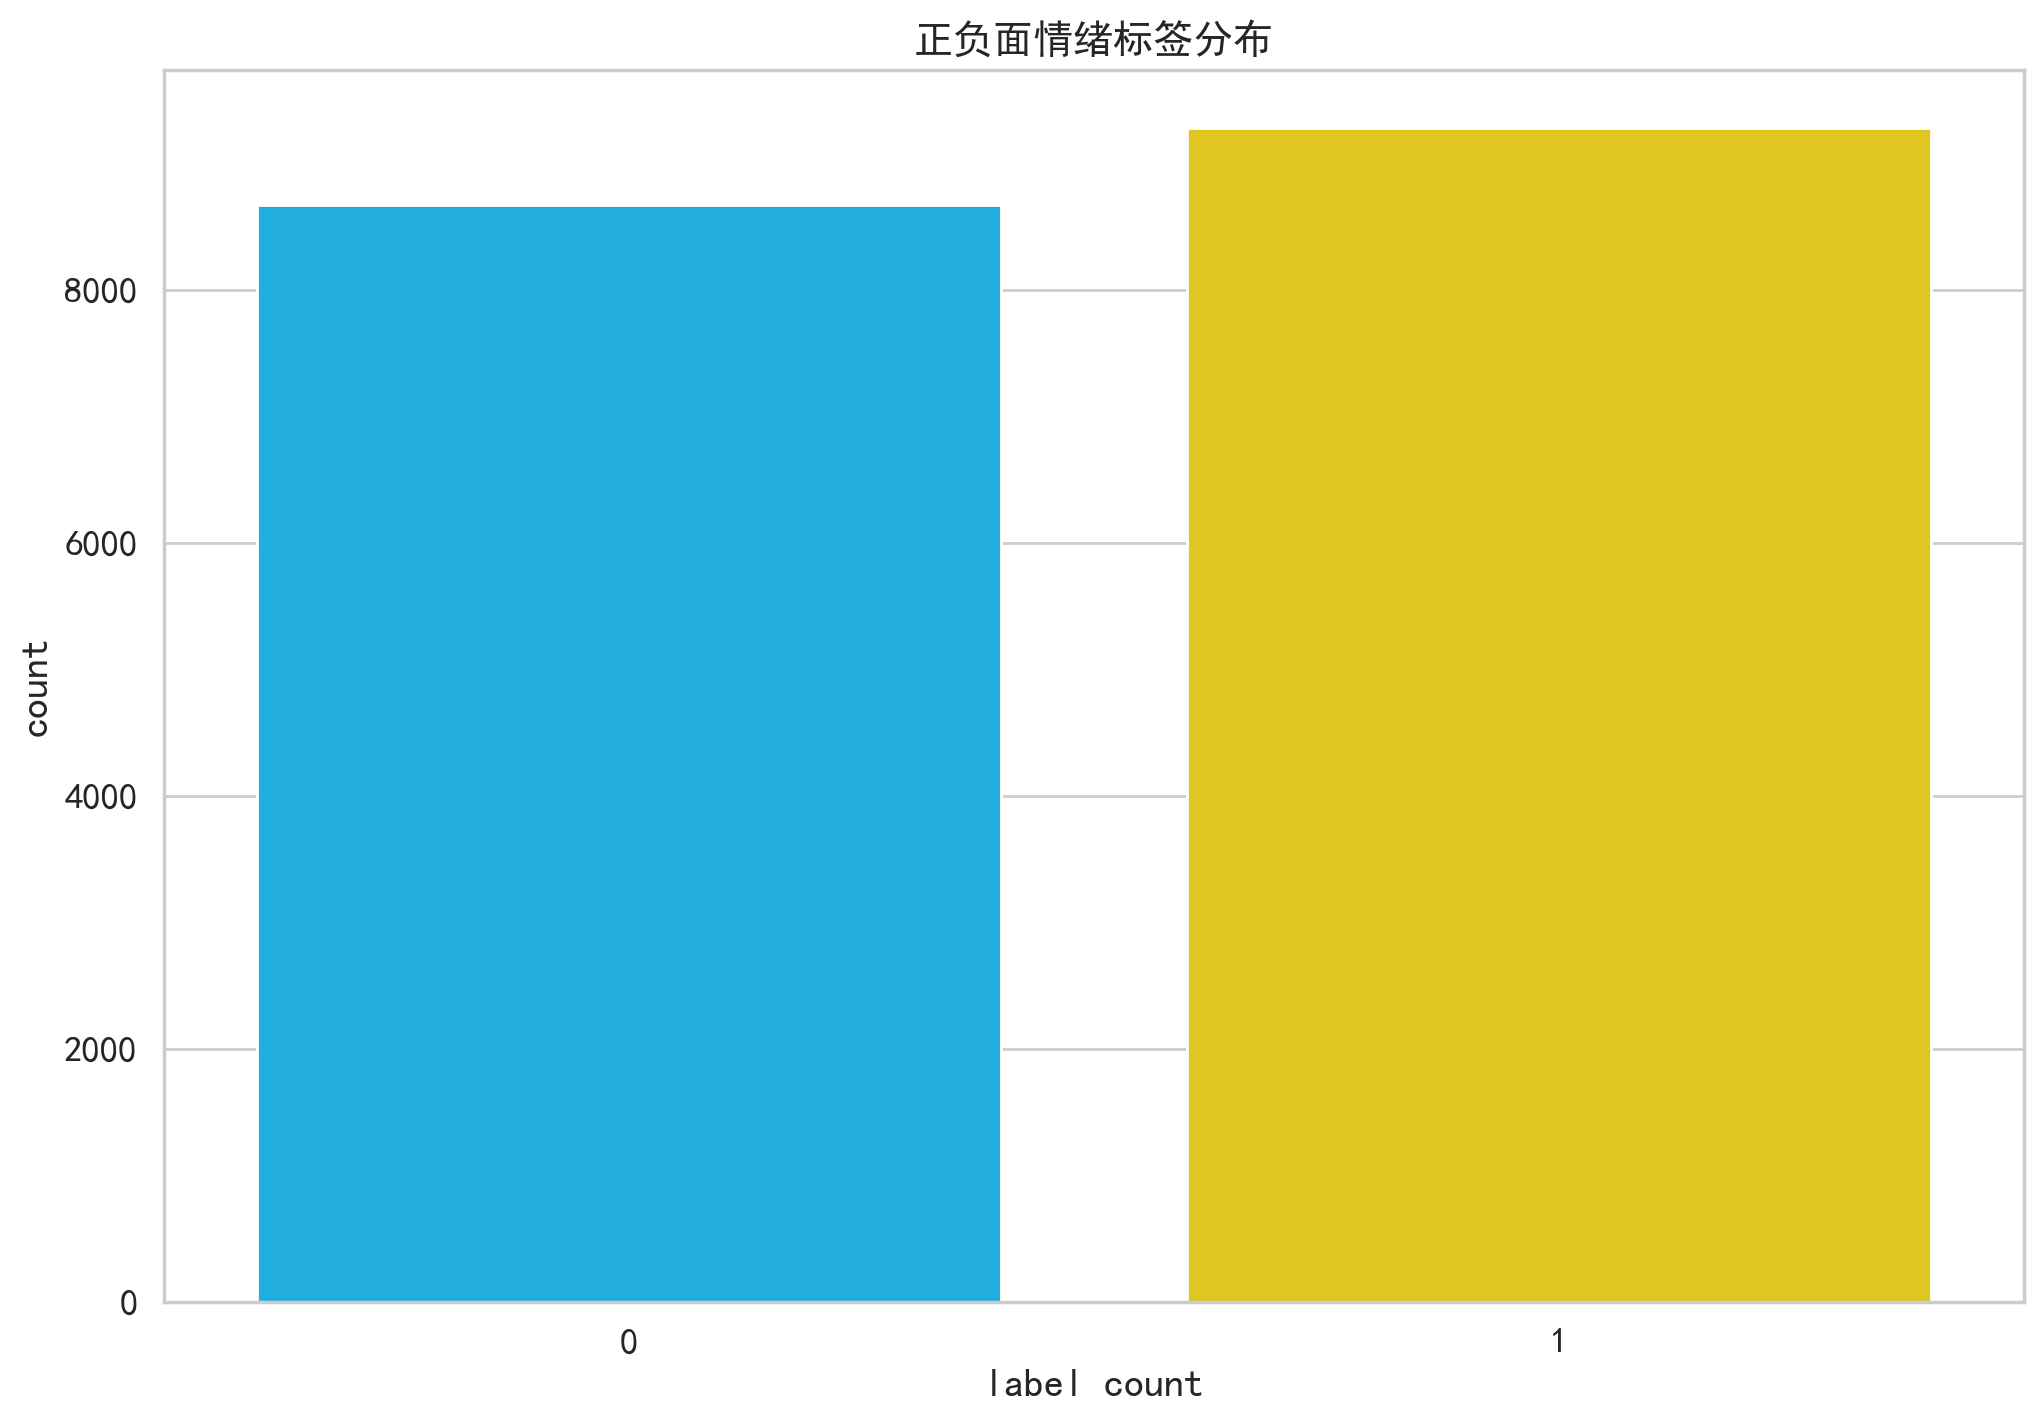

In [38]:
# sns.countplot(train.target)
sns.countplot(x="target", data=train)
plt.title("正负面情绪标签分布")
plt.xlabel('label count')

In [39]:
train.head()

,target,userId,sellerId,timestamp,comment
0,1,127,1708,2019-10-01 00:57:45.000003,text：订餐1个半小时不见餐，催了还挂电话！☆ ☆ ☆
1,1,1661,886,2019-10-01 00:42:07.000001,text：太不靠谱！× × 不是漏发订单就是菜送错了，要不就早送一小时！！！× ×
2,0,92758,10612,2019-10-01 00:51:18.000000,text：超级超级喜欢吃，每次去都好开心，口味很好，建议手套多戴几双，吃完之后的形象是不太好...
3,0,1639,1699,2019-10-03 00:01:56.000001,text：谢谢快递哥哥，非常准时，辛苦啦
4,1,241839,36556,2019-10-01 00:07:56.000004,非常差得餐厅，上菜非常慢，且贵！属于可以在餐厅饿死的那种\n，面条没有味道，一碗28，坑死爹...


In [40]:
train['text_len']=train['comment'].map(len)

In [41]:
train['comment'].map(len).describe()# 298-12=286

count    17953.000000
mean        42.585139
std         23.491501
min          4.000000
25%         20.000000
50%         51.000000
75%         61.000000
max        470.000000
Name: comment, dtype: float64

<AxesSubplot:title={'center':'文本长度的分布'}, ylabel='Density'>

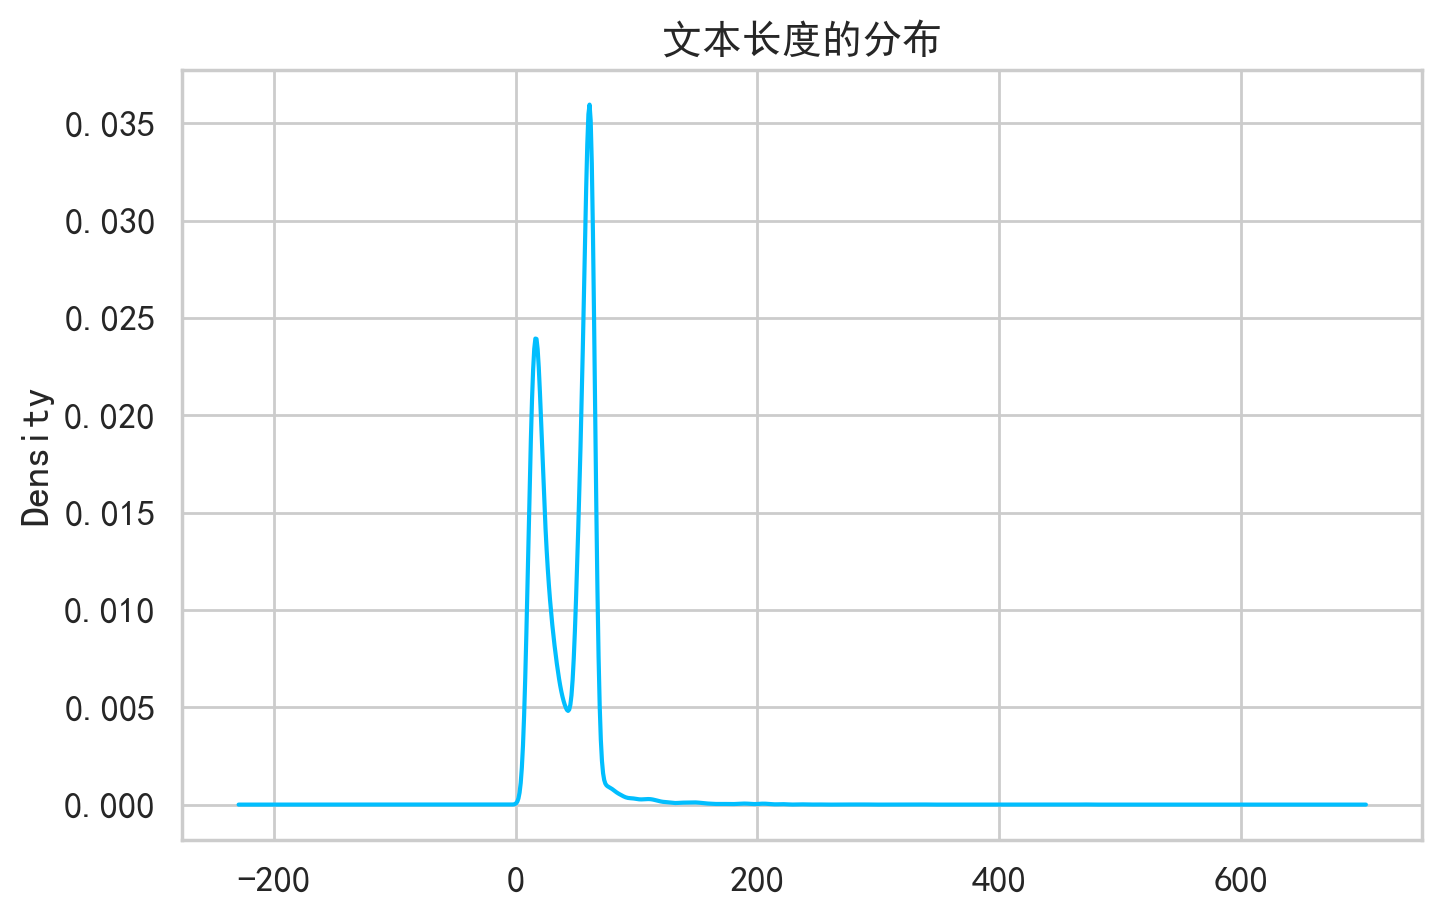

In [42]:
plt.figure(figsize=(8,5))
plt.title('文本长度的分布')
plt.grid()
train['text_len'].plot(kind='kde')

In [43]:
sum(train['text_len']>400) # text文本长度大于100的个数
# sum(train['text_len']>200) # text文本长度大于200的个数

1

# 将文本映射为id表示

In [44]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
# PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm-ext'
# PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm'

# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [46]:
sample_txt = '今天早上9点半起床，我在学习预训练模型的使用.'

In [47]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'文本为: {sample_txt}')
print(f'分词的列表为: {tokens}')
print(f'词对应的唯一id: {token_ids}')

文本为: 今天早上9点半起床，我在学习预训练模型的使用.
分词的列表为: ['今', '天', '早', '上', '9', '点', '半', '起', '床', '，', '我', '在', '学', '习', '预', '训', '练', '模', '型', '的', '使', '用', '.']
词对应的唯一id: [791, 1921, 3193, 677, 130, 4157, 1288, 6629, 2414, 8024, 2769, 1762, 2110, 739, 7564, 6378, 5298, 3563, 1798, 4638, 886, 4500, 119]


## 特殊符号

In [48]:
tokenizer.sep_token, tokenizer.sep_token_id


('[SEP]', 102)

In [49]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [50]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [51]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [52]:
tokenizer.mask_token, tokenizer.mask_token_id

('[MASK]', 103)

In [53]:
encoding=tokenizer.encode_plus(
    sample_txt,
    # sample_txt_another,
    max_length=32,
    add_special_tokens=True,# [CLS]和[SEP]
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',# Pytorch tensor张量

)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [54]:
encoding

{'input_ids': tensor([[ 101,  791, 1921, 3193,  677,  130, 4157, 1288, 6629, 2414, 8024, 2769,
         1762, 2110,  739, 7564, 6378, 5298, 3563, 1798, 4638,  886, 4500,  119,
          102,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])}

In [55]:
print(len(encoding['input_ids'][0]))

32


In [56]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])

In [57]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '今',
 '天',
 '早',
 '上',
 '9',
 '点',
 '半',
 '起',
 '床',
 '，',
 '我',
 '在',
 '学',
 '习',
 '预',
 '训',
 '练',
 '模',
 '型',
 '的',
 '使',
 '用',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# 选取文本最大长度

In [58]:
token_lens = []

for txt in train.comment:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

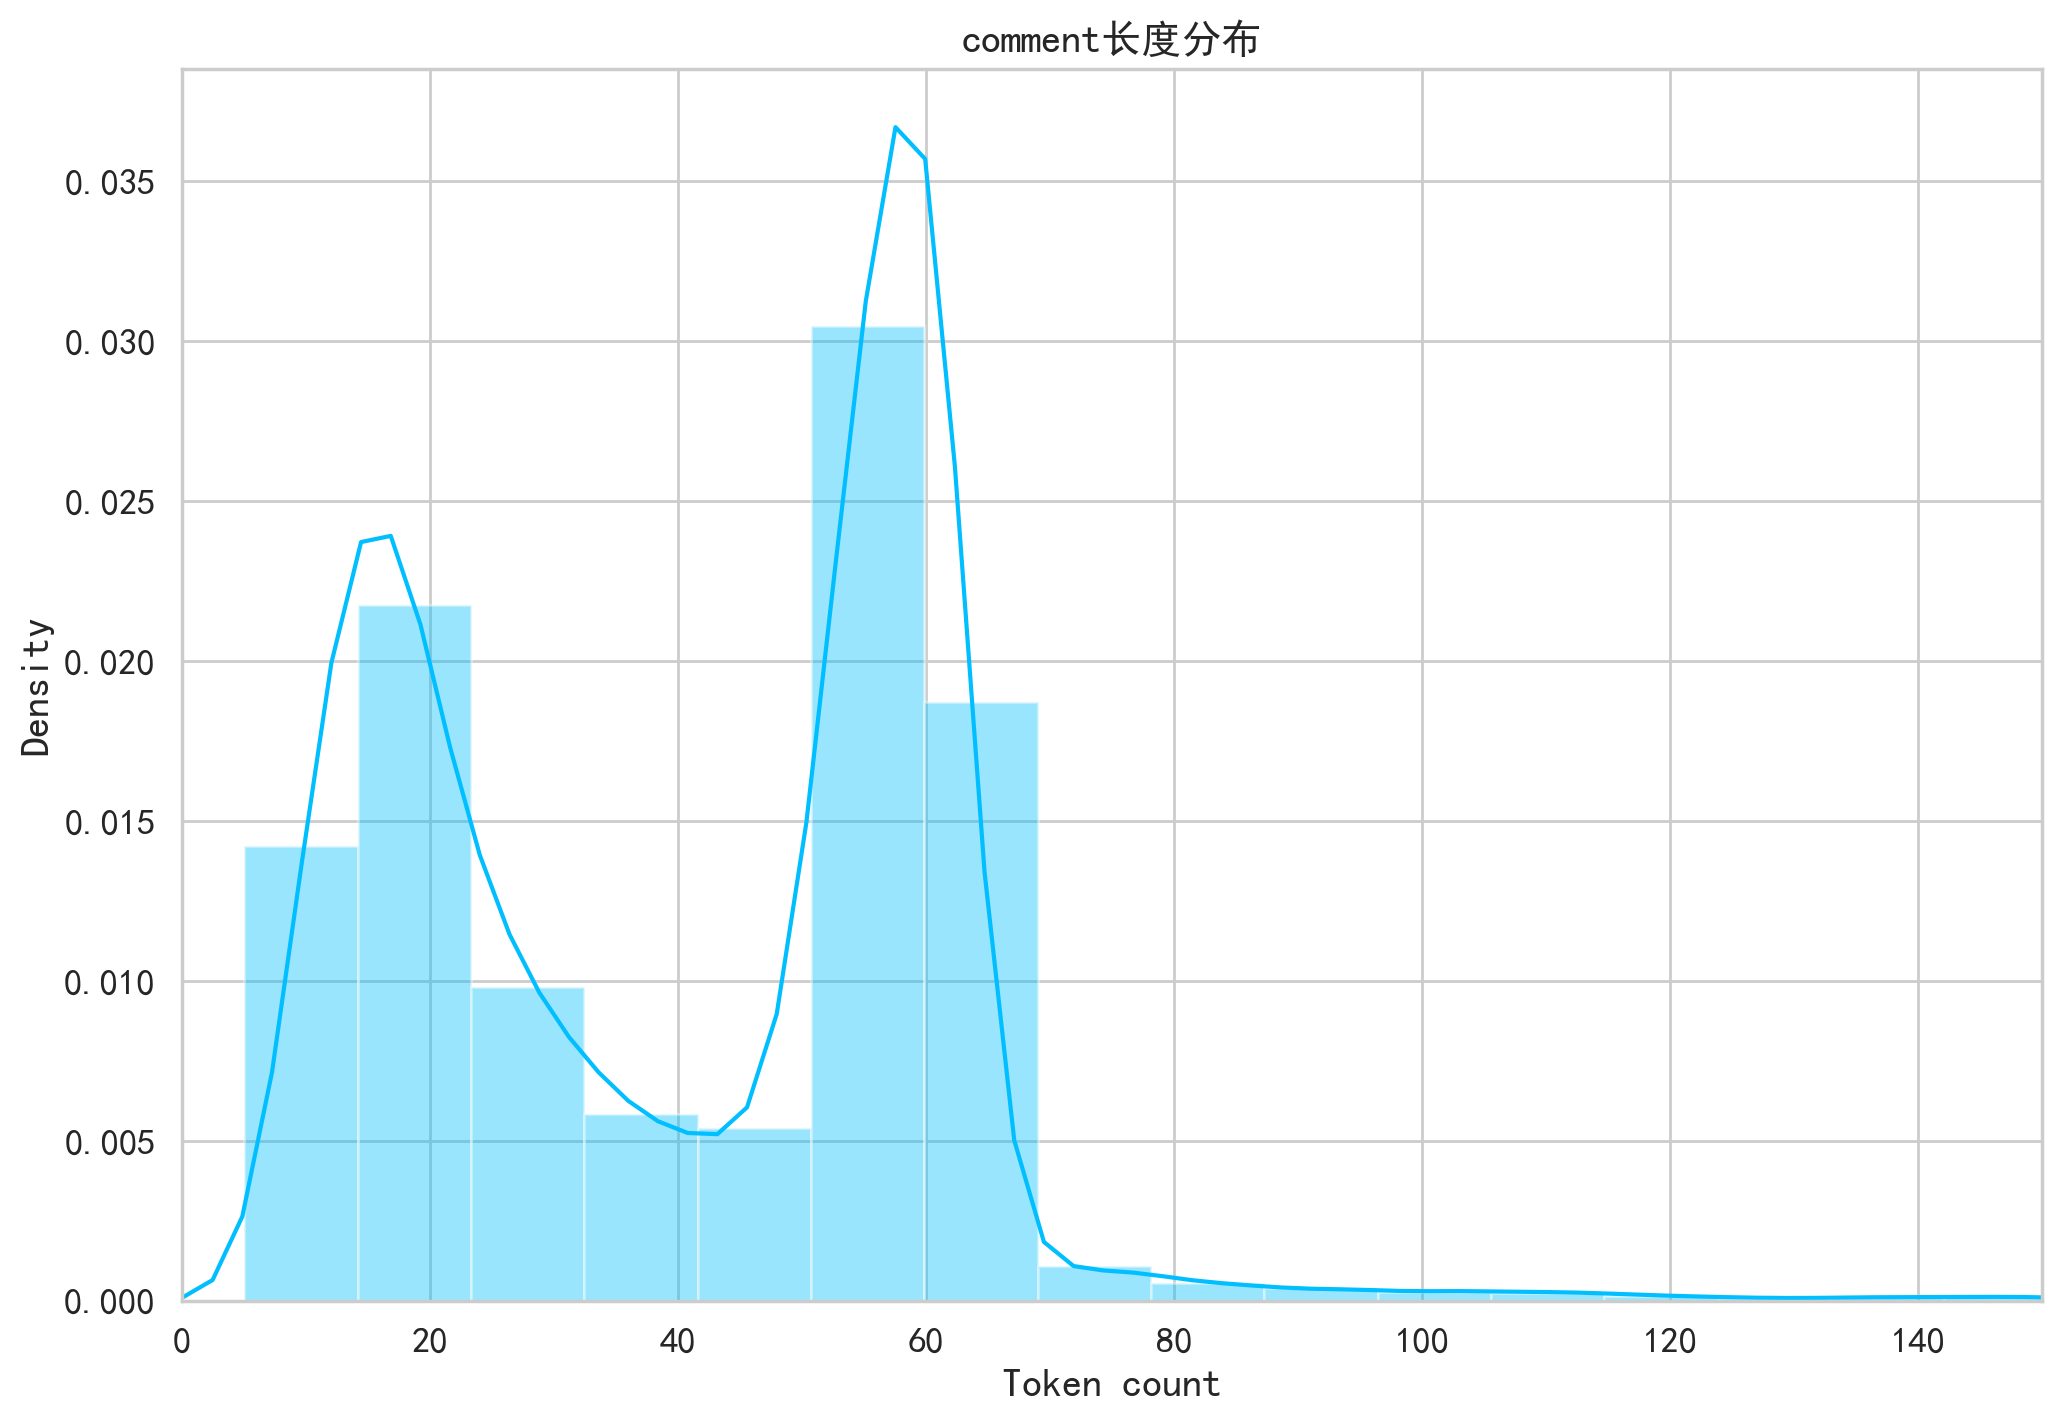

In [59]:
sns.distplot(token_lens)
plt.xlim([0, 150]);
plt.title('comment长度分布')
plt.xlabel('Token count');

In [60]:
MAX_LEN = 80

# 自定义数据集

In [61]:
class EnterpriseDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }
        

# 划分数据集并创建生成器

In [62]:
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((16157, 6), (898, 6), (898, 6))

In [63]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=EnterpriseDataset(
        texts=df['comment'].values,
        labels=df['target'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
    )

In [64]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [65]:
next(iter(train_data_loader))

{'texts': ['text：较之前还是吃的时候腊肉量偏少，不知是不是商家减量还是偶然的情况',
  'text：好吃！叉烧不错！黑椒牛柳粒也很好吃！喜欢男服务员的马褂，准备给老公照样子做一件，然后派他中国大挣钱来。\n',
  'text：送餐少米饭，要了三盒来了两盒，说给你和两盒了',
  'text：很不错。在开发区吃个川菜的首选，环境很好，服务也不错。水煮鱼，鸭下巴都不错。价格也不贵。还有免费水果随时提供。\n'],
 'input_ids': tensor([[  101, 10539,  8038,  6772,   722,  1184,  6820,  3221,  1391,  4638,
           3198,   952,  5572,  5489,  7030,   974,  2208,  8024,   679,  4761,
           3221,   679,  3221,  1555,  2157,  1121,  7030,  6820,  3221,   981,
           4197,  4638,  2658,  1105,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101, 10539,  8038,  1962,  1391,  8013,  1349,  4173,   679,  7231,
           8013,  7946,  3492,  4281,  3394,  510

In [66]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [67]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([4, 80])
torch.Size([4, 80])
torch.Size([4])


# 基于Huggingface 的文本分类

In [68]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [70]:
encoding

{'input_ids': tensor([[ 101,  791, 1921, 3193,  677,  130, 4157, 1288, 6629, 2414, 8024, 2769,
         1762, 2110,  739, 7564, 6378, 5298, 3563, 1798, 4638,  886, 4500,  119,
          102,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])}

In [71]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [72]:
last_hidden_state # 每个token的向量表示

tensor([[[ 0.8880,  0.1987,  1.3610,  ..., -0.5096,  0.3742, -0.2368],
         [-0.0747,  0.3148,  1.4699,  ..., -1.0238, -0.0518, -0.0557],
         [ 1.0133, -0.6058,  1.0152,  ...,  0.3536,  1.1091, -0.1179],
         ...,
         [ 0.1623,  0.1187, -0.0777,  ..., -0.0039, -0.2441, -0.2191],
         [ 0.0909, -0.0089, -0.2200,  ...,  0.3647, -0.2393, -0.2092],
         [ 0.1547,  0.1185, -0.3538,  ...,  0.1968, -0.2967, -0.2775]]],
       grad_fn=<NativeLayerNormBackward0>)

In [89]:
# pooled_output

In [74]:
last_hidden_state.shape # 每个token的向量表示

torch.Size([1, 32, 768])

In [75]:
pooled_output.shape # CLS的向量表示

torch.Size([1, 768])

In [76]:
bert_model.config.hidden_size

768

In [77]:
pooled_output.shape
# 整体句子表示

torch.Size([1, 768])

In [78]:
class EnterpriseDangerClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EnterpriseDangerClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # 两个类别
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [79]:
class_names=[0,1]

In [80]:
model = EnterpriseDangerClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
data

{'texts': ['text：较之前还是吃的时候腊肉量偏少，不知是不是商家减量还是偶然的情况',
  'text：好吃！叉烧不错！黑椒牛柳粒也很好吃！喜欢男服务员的马褂，准备给老公照样子做一件，然后派他中国大挣钱来。\n',
  'text：送餐少米饭，要了三盒来了两盒，说给你和两盒了',
  'text：很不错。在开发区吃个川菜的首选，环境很好，服务也不错。水煮鱼，鸭下巴都不错。价格也不贵。还有免费水果随时提供。\n'],
 'input_ids': tensor([[  101, 10539,  8038,  6772,   722,  1184,  6820,  3221,  1391,  4638,
           3198,   952,  5572,  5489,  7030,   974,  2208,  8024,   679,  4761,
           3221,   679,  3221,  1555,  2157,  1121,  7030,  6820,  3221,   981,
           4197,  4638,  2658,  1105,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101, 10539,  8038,  1962,  1391,  8013,  1349,  4173,   679,  7231,
           8013,  7946,  3492,  4281,  3394,  510

In [82]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 80])
torch.Size([4, 80])


In [83]:
model(input_ids, attention_mask)

tensor([[ 0.3604, -0.2395],
        [ 0.5748, -0.2774],
        [ 0.3380, -0.2521],
        [ 0.6395,  0.5023]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [84]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5083, 0.4917],
        [0.5088, 0.4912],
        [0.6162, 0.3838],
        [0.5424, 0.4576]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# 模型训练

In [85]:
EPOCHS = 3 # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-3, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [86]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train() # train模式
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [87]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [88]:
history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


KeyboardInterrupt: 

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);